In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import soundfile as sf
import joblib

%matplotlib inline

In [2]:
ROOT_DIR = 'D:/ustcCS2024/keshe/UrbanSound8K/audio/'
files = glob.glob(ROOT_DIR+'/**/*')

In [4]:
len(files)

8732

In [5]:
files[0].split('\\')[-1].split('-')[1]

'3'

In [3]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_resample = librosa.resample(y=data.T, orig_sr=fsr, target_sr=sr)
    if len(data_resample.shape) > 1:
        data_resample = np.average(data_resample, axis=0)
    return data_resample, sr

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [4]:
d, sr = get_sound_data(files[0], sr=22050)

In [8]:
len(d), sr

(88200, 22050)

In [5]:
list(windows(d, window_size=512*63))

[(0, 32256),
 (16128, 48384),
 (32256, 64512),
 (48384, 80640),
 (64512, 96768),
 (80640, 112896)]

In [11]:
32256 / 22050

1.4628571428571429

In [6]:
def extract_features(file_names, bands=64, frames=64):
    
    window_size = 512 * (frames - 1)  
    log_specgrams_full = []
    log_specgrams_hp = []
    class_labels = []
    # for each audio sample
    for fn in file_names:
        file_name = fn.split('\\')[-1]
        class_label = file_name.split('-')[1]
        sound_data, sr = get_sound_data(fn, sr=22050)
        # for each audio signal sub-sample window of data
        for (start,end) in windows(sound_data, window_size):
            if(len(sound_data[start:end]) == window_size):
                signal = sound_data[start:end]
                # get the log-scaled mel-spectrogram
                melspec_full = librosa.feature.melspectrogram(y=signal, sr=sr,n_mels = bands)
                logspec_full = librosa.amplitude_to_db(melspec_full)
                logspec_full = logspec_full.T.flatten()[:, np.newaxis].T
                # get the log-scaled, averaged values for the harmonic & percussive components
                y_harmonic, y_percussive = librosa.effects.hpss(signal)
                melspec_harmonic = librosa.feature.melspectrogram(y=y_harmonic, n_mels = bands)
                melspec_percussive = librosa.feature.melspectrogram(y=y_percussive, n_mels = bands)
                logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
                logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
                logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
                logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
                logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)
                
                log_specgrams_full.append(logspec_full)
                log_specgrams_hp.append(logspec_hp)
                class_labels.append(class_label)
    # create the first two feature maps            
    log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
    log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
    features = np.concatenate((log_specgrams_full, 
                               log_specgrams_hp, 
                               np.zeros(np.shape(log_specgrams_full))), 
                              axis=3)
    # create the third feature map which is the delta (derivative) of the log-scaled mel-spectrogram
    for i in range(len(features)):
        features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(class_labels, dtype = int)

In [12]:
features, labels = extract_features(files)
joblib.dump(features, 'features.pkl')
joblib.dump(labels, 'labels.pkl')

['labels.pkl']

In [7]:
features = joblib.load('features.pkl')
labels = joblib.load('labels.pkl')
features.shape, labels.shape

((30500, 64, 64, 3), (30500,))

In [8]:
from collections import Counter

Counter(labels)

Counter({3: 2912,
         6: 336,
         7: 3473,
         5: 3910,
         2: 3947,
         8: 3611,
         9: 4000,
         0: 3993,
         4: 3405,
         1: 913})

In [9]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}

categories = list(set(labels))
sample_idxs = [np.where(labels == label_id)[0][0] for label_id in categories]
feature_samples = features[sample_idxs]
feature_samples.shape

(10, 64, 64, 3)

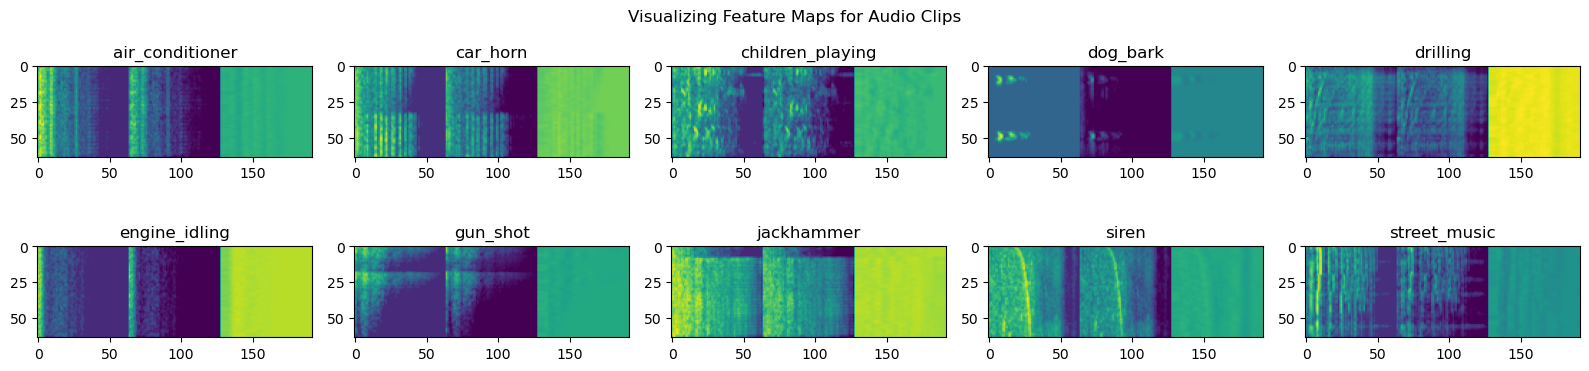

In [10]:
plt.figure(figsize=(16, 4))
for index, (feature_map, category) in enumerate(zip(feature_samples, categories)):
    plt.subplot(2, 5, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(class_map[str(category)])
plt.tight_layout()
t = plt.suptitle('Visualizing Feature Maps for Audio Clips')

In [11]:
features = joblib.load('base_features.pkl')
labels = joblib.load('dataset_labels.pkl')
features.shape, labels.shape

((30500, 64, 64, 3), (30500,))

In [12]:
data = np.array(list(zip(features, labels)), dtype=object)
data.shape

(30500, 2)

In [13]:
np.random.shuffle(data)

In [14]:
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [15]:
train.shape, validate.shape, test.shape

((18300, 2), (6100, 2), (6100, 2))

In [16]:
print('Train:', Counter(item[1] for item in train), 
      '\nValidate:', Counter(item[1] for item in validate), 
      '\nTest:',Counter(item[1] for item in test))

Train: Counter({2: 2453, 9: 2372, 0: 2331, 5: 2323, 8: 2182, 7: 2136, 4: 2010, 3: 1736, 1: 552, 6: 205}) 
Validate: Counter({0: 821, 9: 810, 5: 810, 2: 765, 8: 728, 4: 692, 7: 656, 3: 569, 1: 178, 6: 71}) 
Test: Counter({0: 841, 9: 818, 5: 777, 2: 729, 4: 703, 8: 701, 7: 681, 3: 607, 1: 183, 6: 60})


In [17]:
import tensorflow as tf

# 检查 tensorflow.keras 是否存在
try:
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications import vgg16
    from tensorflow.keras.applications.imagenet_utils import preprocess_input
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.models import Model
    from PIL import Image
    print("tensorflow.keras 存在")
except ImportError:
    print("tensorflow.keras 不存在")

tensorflow.keras 存在


In [18]:
def process_sound_data(data):
    data = np.expand_dims(data, axis=0)
    data = preprocess_input(data)
    return data

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))


output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

model = Model(vgg.input, output)
model.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [20]:
def extract_tl_features(model, base_feature_data):
    dataset_tl_features = []
    for index, feature_data in enumerate(base_feature_data):
        if (index+1) % 1000 == 0:
            print('Finished processing', index+1, 'sound feature maps')
        pr_data = process_sound_data(feature_data)
        tl_features = model.predict(pr_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        dataset_tl_features.append(tl_features)
    return np.array(dataset_tl_features)

In [21]:
train_base_features = [item[0] for item in train]
train_labels = np.array([item[1] for item in train])
train_tl_features = extract_tl_features(model=model, base_feature_data=train_base_features)

1/1 [==============================] - 0s 61ms/step
Finished processing 1000 sound feature maps
1/1 [==============================] - 0s 71ms/step
Finished processing 2000 sound feature maps
1/1 [==============================] - 0s 69ms/step
Finished processing 3000 sound feature maps
1/1 [==============================] - 0s 77ms/step
Finished processing 4000 sound feature maps
1/1 [==============================] - 0s 63ms/step
Finished processing 5000 sound feature maps
1/1 [==============================] - 0s 114ms/step
Finished processing 6000 sound feature maps
1/1 [==============================] - 0s 184ms/step
Finished processing 7000 sound feature maps
1/1 [==============================] - 0s 231ms/step
Finished processing 8000 sound feature maps
1/1 [==============================] - 0s 289ms/step
Finished processing 9000 sound feature maps
1/1 [==============================] - 0s 228ms/step
Finished processing 10000 sound feature maps
1/1 [=============================

In [22]:
joblib.dump(train_tl_features, 'train_tl_features.pkl')
joblib.dump(train_labels, 'train_labels.pkl')

['train_labels.pkl']

In [23]:
train_tl_features.shape, train_labels.shape

((18300, 2048), (18300,))

In [24]:
validate_base_features = [item[0] for item in validate]
validate_labels = np.array([item[1] for item in validate])
validate_tl_features = extract_tl_features(model=model, base_feature_data=validate_base_features)

1/1 [==============================] - 1s 557ms/step
Finished processing 1000 sound feature maps
1/1 [==============================] - 1s 568ms/step
Finished processing 2000 sound feature maps
1/1 [==============================] - 1s 611ms/step
Finished processing 3000 sound feature maps
1/1 [==============================] - 1s 822ms/step
Finished processing 4000 sound feature maps
1/1 [==============================] - 1s 930ms/step
Finished processing 5000 sound feature maps
1/1 [==============================] - 1s 962ms/step
Finished processing 6000 sound feature maps
1/1 [==============================] - 1s 839ms/step


In [25]:
joblib.dump(validate_tl_features, 'validate_tl_features.pkl')
joblib.dump(validate_labels, 'validate_labels.pkl')

['validate_labels.pkl']

In [26]:
test_base_features = [item[0] for item in test]
test_labels = np.array([item[1] for item in test])
test_tl_features = extract_tl_features(model=model, base_feature_data=test_base_features)

1/1 [==============================] - 1s 736ms/step
Finished processing 1000 sound feature maps
1/1 [==============================] - 1s 906ms/step
Finished processing 2000 sound feature maps
1/1 [==============================] - 1s 932ms/step
Finished processing 3000 sound feature maps
1/1 [==============================] - 1s 970ms/step
Finished processing 4000 sound feature maps
1/1 [==============================] - 1s 969ms/step
Finished processing 5000 sound feature maps
1/1 [==============================] - 1s 1s/step
Finished processing 6000 sound feature maps
1/1 [==============================] - 1s 1s/step


In [27]:
joblib.dump(test_tl_features, 'test_tl_features.pkl')
joblib.dump(test_labels, 'test_labels.pkl')

['test_labels.pkl']

In [28]:
train_tl_features.shape, validate_tl_features.shape, test_tl_features.shape

((18300, 2048), (6100, 2048), (6100, 2048))